In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from typing import Any, List, Dict, Tuple, Union
from sklearn.metrics import f1_score, accuracy_score

In [2]:
df1 = pd.read_csv('/kaggle/input/credit-card-details/Credit_card.csv')
df2 = pd.read_csv('/kaggle/input/credit-card-details/Credit_card_label.csv')
df = df1.merge(df2, how='inner', on='Ind_ID')
df.drop('Ind_ID', inplace= True, axis= 1)
orig_columns = list(df.columns)

In [3]:
df

,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members,label
0,M,Y,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,-18772.0,365243,1,0,0,0,NaN,2,1
1,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
2,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,NaN,-586,1,1,1,0,NaN,2,1
3,F,Y,N,0,NaN,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
4,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,F,N,Y,0,NaN,Commercial associate,Higher education,Married,House / apartment,-11957.0,-2182,1,0,0,0,Managers,2,0
1544,F,N,N,0,225000.0,Commercial associate,Incomplete higher,Single / not married,House / apartment,-10229.0,-1209,1,0,0,0,Accountants,1,0
1545,M,Y,Y,2,180000.0,Working,Higher education,Married,House / apartment,-13174.0,-2477,1,0,0,0,Managers,4,0
1546,M,Y,N,0,270000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-15292.0,-645,1,1,1,0,Drivers,2,0


In [4]:
df.describe()

,CHILDREN,Annual_income,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Family_Members,label
count,1548.000000,1.525000e+03,1526.000000,1548.000000,1548.0,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000
mean,0.412791,1.913993e+05,-16040.342071,59364.689922,1.0,0.208010,0.309432,0.092377,2.161499,0.113049
std,0.776691,1.132530e+05,4229.503202,137808.062701,0.0,0.406015,0.462409,0.289651,0.947772,0.316755
min,0.000000,3.375000e+04,-24946.000000,-14887.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,1.215000e+05,-19553.000000,-3174.500000,1.0,0.000000,0.000000,0.000000,2.000000,0.000000
50%,0.000000,1.665000e+05,-15661.500000,-1565.000000,1.0,0.000000,0.000000,0.000000,2.000000,0.000000
75%,1.000000,2.250000e+05,-12417.000000,-431.750000,1.0,0.000000,1.000000,0.000000,3.000000,0.000000
max,14.000000,1.575000e+06,-7705.000000,365243.000000,1.0,1.000000,1.000000,1.000000,15.000000,1.000000


### About choosing scales for features
I chose scale from this reasons:

For numerical data, I used the ordinal scale, so for classification you need to split by bin. Ideally, the beans should be selected using quantiles, I will add this in the final implementation

For categorical ones, I used the Nominal scale

For binary features that take values of 0 or 1, I used the dichotomic scale

### Ordinal scale
Features to scale: Annual_income, Birthday_count, Employed_days, CHILDREN, Family_members

In [5]:
def make_bins(column, n_bins= 4):
    min_val = df[column].min()
    max_val = df[column].max()
    bins = np.linspace(min_val, max_val, n_bins + 1) #Надо разбивать по квантилям, исправлю позднее
    return bins

def create_labels(bins):
    return [f'[{bins[i]:.2f}, {bins[-1]:.2f}]' for i in range(len(bins) - 1)]


def categorize_column(df, column, n_bins):
    
    bins = make_bins(column, n_bins)
    labels = create_labels(bins)
   

    for i in range(len(bins) - 1):
 
        df[f'belongs_to_{column}_{labels[i]}'] = df[column].between(bins[i], bins[-1], inclusive='both')
        df[f'belongs_to_{column}_{labels[i]}'] = df[f'belongs_to_{column}_{labels[i]}'].apply(lambda x: True if x == True else False)
numerical_columns = df.select_dtypes(include=[np.number]).columns.drop(['label','Mobile_phone','Work_Phone', 'Phone','EMAIL_ID'])
n_bins = 4  

for column in numerical_columns:
    categorize_column(df, column, n_bins)

df

,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members,label,"belongs_to_CHILDREN_[0.00, 14.00]","belongs_to_CHILDREN_[3.50, 14.00]","belongs_to_CHILDREN_[7.00, 14.00]","belongs_to_CHILDREN_[10.50, 14.00]","belongs_to_Annual_income_[33750.00, 1575000.00]","belongs_to_Annual_income_[419062.50, 1575000.00]","belongs_to_Annual_income_[804375.00, 1575000.00]","belongs_to_Annual_income_[1189687.50, 1575000.00]","belongs_to_Birthday_count_[-24946.00, -7705.00]","belongs_to_Birthday_count_[-20635.75, -7705.00]","belongs_to_Birthday_count_[-16325.50, -7705.00]","belongs_to_Birthday_count_[-12015.25, -7705.00]","belongs_to_Employed_days_[-14887.00, 365243.00]","belongs_to_Employed_days_[80145.50, 365243.00]","belongs_to_Employed_days_[175178.00, 365243.00]","belongs_to_Employed_days_[270210.50, 365243.00]","belongs_to_Family_Members_[1.00, 15.00]","belongs_to_Family_Members_[4.50, 15.00]","belongs_to_Family_Members_[8.00, 15.00]","belongs_to_Family_Members_[11.50, 15.00]"
0,M,Y,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,-18772.0,365243,1,0,0,0,NaN,2,1,True,False,False,False,True,False,False,False,True,True,False,False,True,True,True,True,True,False,False,False
1,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1,True,False,False,False,True,False,False,False,True,True,True,False,True,False,False,False,True,False,False,False
2,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,NaN,-586,1,1,1,0,NaN,2,1,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False
3,F,Y,N,0,NaN,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1,True,False,False,False,False,False,False,False,True,True,True,False,True,False,False,False,True,False,False,False
4,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1,True,False,False,False,True,False,False,False,True,True,True,False,True,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,F,N,Y,0,NaN,Commercial associate,Higher education,Married,House / apartment,-11957.0,-2182,1,0,0,0,Managers,2,0,True,False,False,False,False,False,False,False,True,True,True,True,True,False,False,False,True,False,False,False
1544,F,N,N,0,225000.0,Commercial associate,Incomplete higher,Single / not married,House / apartment,-10229.0,-1209,1,0,0,0,Accountants,1,0,True,False,False,False,True,False,False,False,True,True,True,True,True,False,False,False,True,False,False,False
1545,M,Y,Y,2,180000.0,Working,Higher education,Married,House / apartment,-13174.0,-2477,1,0,0,0,Managers,4,0,True,False,False,False,True,False,False,False,True,True,True,False,True,False,False,False,True,False,False,False
1546,M,Y,N,0,270000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-15292.0,-645,1,1,1,0,Drivers,2,0,True,False,False,False,True,False,False,False,True,True,True,False,True,False,False,False,True,False,False,False


### Dichotomic scale

Features to scale: Mobile_phone,Work_Phone, Phone,EMAIL_ID

In [6]:
binary_columns = ['Mobile_phone', 'Work_Phone', 'Phone', 'EMAIL_ID']

for column in binary_columns:
    df[f'{column}_yes'] = df[column].apply(lambda x: True if x == 1 else False)  
    df[f'{column}_no'] = df[column].apply(lambda x: True if x == 0 else False)  

df

,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members,label,"belongs_to_CHILDREN_[0.00, 14.00]","belongs_to_CHILDREN_[3.50, 14.00]","belongs_to_CHILDREN_[7.00, 14.00]","belongs_to_CHILDREN_[10.50, 14.00]","belongs_to_Annual_income_[33750.00, 1575000.00]","belongs_to_Annual_income_[419062.50, 1575000.00]","belongs_to_Annual_income_[804375.00, 1575000.00]","belongs_to_Annual_income_[1189687.50, 1575000.00]","belongs_to_Birthday_count_[-24946.00, -7705.00]","belongs_to_Birthday_count_[-20635.75, -7705.00]","belongs_to_Birthday_count_[-16325.50, -7705.00]","belongs_to_Birthday_count_[-12015.25, -7705.00]","belongs_to_Employed_days_[-14887.00, 365243.00]","belongs_to_Employed_days_[80145.50, 365243.00]","belongs_to_Employed_days_[175178.00, 365243.00]","belongs_to_Employed_days_[270210.50, 365243.00]","belongs_to_Family_Members_[1.00, 15.00]","belongs_to_Family_Members_[4.50, 15.00]","belongs_to_Family_Members_[8.00, 15.00]","belongs_to_Family_Members_[11.50, 15.00]",Mobile_phone_yes,Mobile_phone_no,Work_Phone_yes,Work_Phone_no,Phone_yes,Phone_no,EMAIL_ID_yes,EMAIL_ID_no
0,M,Y,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,-18772.0,365243,1,0,0,0,NaN,2,1,True,False,False,False,True,False,False,False,True,True,False,False,True,True,True,True,True,False,False,False,True,False,False,True,False,True,False,True
1,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1,True,False,False,False,True,False,False,False,True,True,True,False,True,False,False,False,True,False,False,False,True,False,True,False,True,False,False,True
2,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,NaN,-586,1,1,1,0,NaN,2,1,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,True,False,True,False,False,True
3,F,Y,N,0,NaN,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1,True,False,False,False,False,False,False,False,True,True,True,False,True,False,False,False,True,False,False,False,True,False,True,False,True,False,False,True
4,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1,True,False,False,False,True,False,False,False,True,True,True,False,True,False,False,False,True,False,False,False,True,False,True,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,F,N,Y,0,NaN,Commercial associate,Higher education,Married,House / apartment,-11957.0,-2182,1,0,0,0,Managers,2,0,True,False,False,False,False,False,False,False,True,True,True,True,True,False,False,False,True,False,False,False,True,False,False,True,False,True,False,True
1544,F,N,N,0,225000.0,Commercial associate,Incomplete higher,Single / not married,House / apartment,-10229.0,-1209,1,0,0,0,Accountants,1,0,True,False,False,False,True,False,False,False,True,True,True,True,True,False,False,False,True,False,False,False,True,False,False,True,False,True,False,True
1545,M,Y,Y,2,180000.0,Working,Higher education,Married,House / apartment,-13174.0,-2477,1,0,0,0,Managers,4,0,True,False,False,False,True,False,False,False,True,True,True,False,True,False,False,False,True,False,False,False,True,False,False,True,False,True,False,True
1546,M,Y,N,0,270000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-15292.0,-645,1,1,1,0,Drivers,2,0,True,False,False,False,True,False,False,False,True,True,True,False,True,False,False,False,True,False,False,False,True,False,True,False,True,False,False,True


### Nominal scale
Features to scale: 'GENDER', 'Car_Owner', Propert_Owner, Type_Income, EDUCATION, Marital_status, Housing_type, Type_Occupation

In [7]:
categorical_columns = ['GENDER', 'Car_Owner', 'Propert_Owner', 'Type_Income', 'EDUCATION', 'Marital_status', 'Housing_type', 'Type_Occupation']
df = pd.get_dummies(df, columns=categorical_columns, drop_first= False)

df

,CHILDREN,Annual_income,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Family_Members,label,"belongs_to_CHILDREN_[0.00, 14.00]","belongs_to_CHILDREN_[3.50, 14.00]","belongs_to_CHILDREN_[7.00, 14.00]","belongs_to_CHILDREN_[10.50, 14.00]","belongs_to_Annual_income_[33750.00, 1575000.00]","belongs_to_Annual_income_[419062.50, 1575000.00]","belongs_to_Annual_income_[804375.00, 1575000.00]","belongs_to_Annual_income_[1189687.50, 1575000.00]","belongs_to_Birthday_count_[-24946.00, -7705.00]","belongs_to_Birthday_count_[-20635.75, -7705.00]","belongs_to_Birthday_count_[-16325.50, -7705.00]","belongs_to_Birthday_count_[-12015.25, -7705.00]","belongs_to_Employed_days_[-14887.00, 365243.00]","belongs_to_Employed_days_[80145.50, 365243.00]","belongs_to_Employed_days_[175178.00, 365243.00]","belongs_to_Employed_days_[270210.50, 365243.00]","belongs_to_Family_Members_[1.00, 15.00]","belongs_to_Family_Members_[4.50, 15.00]","belongs_to_Family_Members_[8.00, 15.00]","belongs_to_Family_Members_[11.50, 15.00]",Mobile_phone_yes,Mobile_phone_no,Work_Phone_yes,Work_Phone_no,Phone_yes,Phone_no,EMAIL_ID_yes,EMAIL_ID_no,GENDER_F,GENDER_M,Car_Owner_N,Car_Owner_Y,Propert_Owner_N,Propert_Owner_Y,Type_Income_Commercial associate,Type_Income_Pensioner,Type_Income_State servant,Type_Income_Working,EDUCATION_Academic degree,EDUCATION_Higher education,EDUCATION_Incomplete higher,EDUCATION_Lower secondary,EDUCATION_Secondary / secondary special,Marital_status_Civil marriage,Marital_status_Married,Marital_status_Separated,Marital_status_Single / not married,Marital_status_Widow,Housing_type_Co-op apartment,Housing_type_House / apartment,Housing_type_Municipal apartment,Housing_type_Office apartment,Housing_type_Rented apartment,Housing_type_With parents,Type_Occupation_Accountants,Type_Occupation_Cleaning staff,Type_Occupation_Cooking staff,Type_Occupation_Core staff,Type_Occupation_Drivers,Type_Occupation_HR staff,Type_Occupation_High skill tech staff,Type_Occupation_IT staff,Type_Occupation_Laborers,Type_Occupation_Low-skill Laborers,Type_Occupation_Managers,Type_Occupation_Medicine staff,Type_Occupation_Private service staff,Type_Occupation_Realty agents,Type_Occupation_Sales staff,Type_Occupation_Secretaries,Type_Occupation_Security staff,Type_Occupation_Waiters/barmen staff
0,0,180000.0,-18772.0,365243,1,0,0,0,2,1,True,False,False,False,True,False,False,False,True,True,False,False,True,True,True,True,True,False,False,False,True,False,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,0,315000.0,-13557.0,-586,1,1,1,0,2,1,True,False,False,False,True,False,False,False,True,True,True,False,True,False,False,False,True,False,False,False,True,False,True,False,True,False,False,True,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,0,315000.0,NaN,-586,1,1,1,0,2,1,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,True,False,True,False,False,True,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,0,NaN,-13557.0,-586,1,1,1,0,2,1,True,False,False,False,False,False,False,False,True,True,True,False,True,False,False,False,True,False,False,False,True,False,True,False,True,False,False,True,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,

### Result

In [8]:
df.drop(['CHILDREN', 'Annual_income','Birthday_count', 'Employed_days','Mobile_phone','Work_Phone','Phone','EMAIL_ID','Family_Members'], axis= 1, inplace= True)
df

,label,"belongs_to_CHILDREN_[0.00, 14.00]","belongs_to_CHILDREN_[3.50, 14.00]","belongs_to_CHILDREN_[7.00, 14.00]","belongs_to_CHILDREN_[10.50, 14.00]","belongs_to_Annual_income_[33750.00, 1575000.00]","belongs_to_Annual_income_[419062.50, 1575000.00]","belongs_to_Annual_income_[804375.00, 1575000.00]","belongs_to_Annual_income_[1189687.50, 1575000.00]","belongs_to_Birthday_count_[-24946.00, -7705.00]","belongs_to_Birthday_count_[-20635.75, -7705.00]","belongs_to_Birthday_count_[-16325.50, -7705.00]","belongs_to_Birthday_count_[-12015.25, -7705.00]","belongs_to_Employed_days_[-14887.00, 365243.00]","belongs_to_Employed_days_[80145.50, 365243.00]","belongs_to_Employed_days_[175178.00, 365243.00]","belongs_to_Employed_days_[270210.50, 365243.00]","belongs_to_Family_Members_[1.00, 15.00]","belongs_to_Family_Members_[4.50, 15.00]","belongs_to_Family_Members_[8.00, 15.00]","belongs_to_Family_Members_[11.50, 15.00]",Mobile_phone_yes,Mobile_phone_no,Work_Phone_yes,Work_Phone_no,Phone_yes,Phone_no,EMAIL_ID_yes,EMAIL_ID_no,GENDER_F,GENDER_M,Car_Owner_N,Car_Owner_Y,Propert_Owner_N,Propert_Owner_Y,Type_Income_Commercial associate,Type_Income_Pensioner,Type_Income_State servant,Type_Income_Working,EDUCATION_Academic degree,EDUCATION_Higher education,EDUCATION_Incomplete higher,EDUCATION_Lower secondary,EDUCATION_Secondary / secondary special,Marital_status_Civil marriage,Marital_status_Married,Marital_status_Separated,Marital_status_Single / not married,Marital_status_Widow,Housing_type_Co-op apartment,Housing_type_House / apartment,Housing_type_Municipal apartment,Housing_type_Office apartment,Housing_type_Rented apartment,Housing_type_With parents,Type_Occupation_Accountants,Type_Occupation_Cleaning staff,Type_Occupation_Cooking staff,Type_Occupation_Core staff,Type_Occupation_Drivers,Type_Occupation_HR staff,Type_Occupation_High skill tech staff,Type_Occupation_IT staff,Type_Occupation_Laborers,Type_Occupation_Low-skill Laborers,Type_Occupation_Managers,Type_Occupation_Medicine staff,Type_Occupation_Private service staff,Type_Occupation_Realty agents,Type_Occupation_Sales staff,Type_Occupation_Secretaries,Type_Occupation_Security staff,Type_Occupation_Waiters/barmen staff
0,1,True,False,False,False,True,False,False,False,True,True,False,False,True,True,True,True,True,False,False,False,True,False,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,1,True,False,False,False,True,False,False,False,True,True,True,False,True,False,False,False,True,False,False,False,True,False,True,False,True,False,False,True,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,1,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,True,False,True,False,False,True,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,1,True,False,False,False,False,False,False,False,True,True,True,False,True,False,False,False,True,False,False,False,True,False,True,False,True,False,False,True,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,1,True,False,False,False,True,False,False,False,True,True,True,False,True,False,False,False,True,False,False,False,True,Fa

# Lazy FCA

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
class LazyClassifierFCA:
    def __init__(self):
        self.X_train = None
        self.y_train = None

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series) -> None:
        self.X_train = X_train
        self.y_train = y_train
        
    def classify_sample(self, sample: pd.Series) -> Any:
        # Split X_train into positive and negative classes
        X_train_positive = self.X_train[y_train == 1]
        X_train_negative = self.X_train[y_train == 0]
        
        positive_classifiers = 0
        negative_classifiers = 0
        
        # Function to check if intersection with a train sample is a positive classifier
        def is_positive_classifier(intersection):
            # Find samples in X_train_positive that contain the intersection
            num_positive = ((X_train_positive | ~intersection) == True).all(axis=1).sum()
            num_negative = ((X_train_negative | ~intersection) == True).all(axis=1).sum()
            return num_negative == 0 and num_positive > 1
        
        # Function to check if intersection is a negative classifier
        def is_negative_classifier(intersection):
            # Find samples in X_train_negative that contain the intersection
            num_positive = ((X_train_positive | ~intersection) == True).all(axis=1).sum()
            num_negative = ((X_train_negative | ~intersection) == True).all(axis=1).sum()
            return num_positive == 0 and num_negative > 1
        
        # Check for positive classifiers by intersecting sample with each positive object
        for _, pos_sample in X_train_positive.iterrows():
            intersection = sample & pos_sample
            if is_positive_classifier(intersection):
                positive_classifiers += 1

        # Check for negative classifiers by intersecting sample with each negative object
        for _, neg_sample in X_train_negative.iterrows():
            intersection = sample & neg_sample
            if is_negative_classifier(intersection):
                negative_classifiers += 1

        # Determine the class based on the number of classifiers
        if positive_classifiers > negative_classifiers:
            print(f"sample {sample.name} is classified as 1, {positive_classifiers=}, {negative_classifiers=}")
            return 1  # Predict positive
            
        elif negative_classifiers > positive_classifiers:
            print(f"sample {sample.name} is classified as 0, {positive_classifiers=}, {negative_classifiers=}")
            return 0  # Predict negative

        else:
            # If equal, you can decide on a rule, like defaulting to 0 or 1, or returning 'undetermined'
            print(f"sample {sample.name} is classified as 1, default, {positive_classifiers=}, {negative_classifiers=}")
        
            return 1  # or 0, depending on the choice


    def predict(self, X_test: pd.DataFrame) -> List[Any]:
        # List to store predictions for each test sample
        predictions = []
        
        # Iterate through each sample in X_test
        for _, sample in X_test.iterrows():
            # Classify the sample and append the result to predictions
            prediction = self.classify_sample(sample)
            predictions.append(prediction)
        
        return predictions

In [11]:
X = df.drop('label', axis=1)  
y = df['label']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
classifier = LazyClassifierFCA()
classifier.fit(X_train, y_train)

In [13]:
predictions = classifier.predict(X_test)

sample 30 is classified as 0, positive_classifiers=0, negative_classifiers=20
sample 1514 is classified as 0, positive_classifiers=0, negative_classifiers=6
sample 1182 is classified as 0, positive_classifiers=0, negative_classifiers=93
sample 1205 is classified as 0, positive_classifiers=0, negative_classifiers=36
sample 528 is classified as 0, positive_classifiers=0, negative_classifiers=116
sample 76 is classified as 0, positive_classifiers=0, negative_classifiers=60
sample 366 is classified as 0, positive_classifiers=0, negative_classifiers=141
sample 704 is classified as 0, positive_classifiers=0, negative_classifiers=35
sample 906 is classified as 0, positive_classifiers=0, negative_classifiers=26
sample 1075 is classified as 1, default, positive_classifiers=0, negative_classifiers=0
sample 1379 is classified as 0, positive_classifiers=0, negative_classifiers=74
sample 1322 is classified as 0, positive_classifiers=0, negative_classifiers=30
sample 428 is classified as 0, positive

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [15]:
def get_metrics(y_test, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fdr = fp / (tp + fp) if (tp + fp) > 0 else 0
    
    print(f"True Positives (TP): {tp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall (True Positive Rate): {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"True Negative Rate (Specificity): {specificity:.2f}")
    print(f"Negative Predictive Value (NPV): {npv:.2f}")
    print(f"False Positive Rate (FPR): {fpr:.2f}")
    print(f"False Discovery Rate (FDR): {fdr:.2f}")
    
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation = 45)
    plt.show()

### Lazy_FCA metrics

True Positives (TP): 15
True Negatives (TN): 251
False Positives (FP): 29
False Negatives (FN): 15
Accuracy: 0.86
Precision: 0.34
Recall (True Positive Rate): 0.50
F1 Score: 0.41
True Negative Rate (Specificity): 0.90
Negative Predictive Value (NPV): 0.94
False Positive Rate (FPR): 0.10
False Discovery Rate (FDR): 0.66


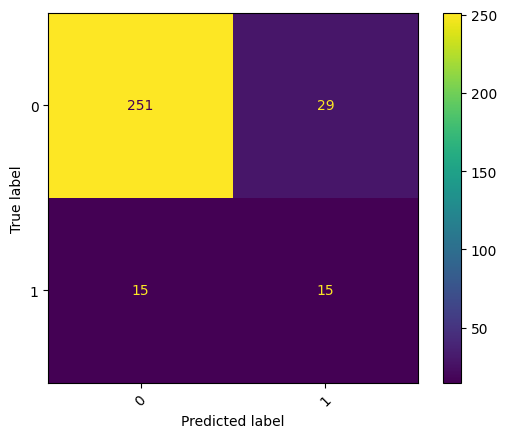

In [16]:
get_metrics(y_test, predictions)

### LogReg metrics

True Positives (TP): 1
True Negatives (TN): 280
False Positives (FP): 0
False Negatives (FN): 29
Accuracy: 0.91
Precision: 1.00
Recall (True Positive Rate): 0.03
F1 Score: 0.06
True Negative Rate (Specificity): 1.00
Negative Predictive Value (NPV): 0.91
False Positive Rate (FPR): 0.00
False Discovery Rate (FDR): 0.00


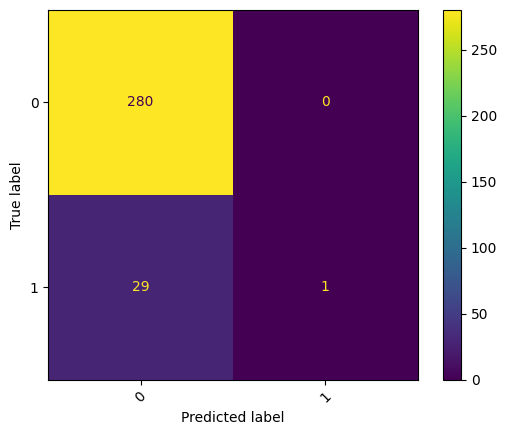

In [17]:
from sklearn.linear_model import LogisticRegression  

model = LogisticRegression(penalty= 'l2')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

get_metrics(y_test, y_pred)

### RandomForest metrics

True Positives (TP): 5
True Negatives (TN): 277
False Positives (FP): 3
False Negatives (FN): 25
Accuracy: 0.91
Precision: 0.62
Recall (True Positive Rate): 0.17
F1 Score: 0.26
True Negative Rate (Specificity): 0.99
Negative Predictive Value (NPV): 0.92
False Positive Rate (FPR): 0.01
False Discovery Rate (FDR): 0.38


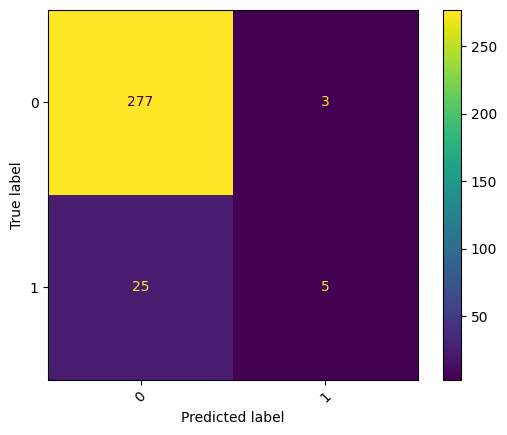

In [18]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)  
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
get_metrics(y_test, y_pred)